# **Implementing sequence-to-sequence model with attention**
- Please make sure you use GPU by setting the menu: Runtime > change runtime type > GPU

## **Preparing Data**

In [1]:
!apt install python3.7
!pip install -U torchtext==0.6.0
!pip install einops
!python -m spacy download en
!python -m spacy download de

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3.7 is already the newest version (3.7.17-1+jammy1).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
2023-11-12 13:18:41.312218: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-12 13:18:41.312278: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-12 13:18:41.312321: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-12 13:18:41.321196: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU inst

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

import spacy
import numpy as np
from einops import rearrange, repeat

import random
import math
import time

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
!git clone https://github.com/neychev/small_DL_repo.git

fatal: destination path 'small_DL_repo' already exists and is not an empty directory.


In [4]:
!mkdir ./data
!mkdir ./data/multi30k

mkdir: cannot create directory ‘./data’: File exists
mkdir: cannot create directory ‘./data/multi30k’: File exists


In [5]:
!tar -zxvf ./small_DL_repo/datasets/Multi30k/training.tar.gz -C ./data/multi30k

train.de
train.en


In [6]:
!tar -zxvf ./small_DL_repo/datasets/Multi30k/validation.tar.gz -C ./data/multi30k

val.de
val.en


In [7]:
!tar -zxvf ./small_DL_repo/datasets/Multi30k/mmt_task1_test2016.tar.gz -C ./data/multi30k

test2016.fr
test2016.en
test2016.de


In [8]:
# !tar -zxvf ./small_DL_repo/datasets/Multi30k/mmt16_task1_test.tar.gz -C ./data/

### **Tokenizers**
- We convert sentences to individual tokens by using tokenizers.
  - e.g. "good morning!" becomes ["good", "morning", "!"]
- We will use python package `spaCy` for this

In [9]:
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

In [10]:
def tokenize_de(text):
  return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
  return [tok.text for tok in spacy_en.tokenizer(text)]

We use Field library to process data. By setting batch_first = True, we set the batch dimension comes first.

In [11]:
SRC = Field(tokenize= tokenize_de,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True,
            batch_first = True)

TRG = Field(tokenize= tokenize_en,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True,
            batch_first = True)

We use Multi30k dataset of about 30k English, Deutch, and French sentences, and each sentence has 12 words. We set exts as the langauges for source and target languages.

In [12]:
# Multi30k.urls[0] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/training.tar.gz"
# Multi30k.urls[1] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/validation.tar.gz"
# Multi30k.urls[2] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/mmt_task1_test2016.tar.gz"

In [13]:
train_data, valid_data, test_data = Multi30k.splits(exts= ('.de', '.en'),
                                                    fields = (SRC, TRG),
                                                    root='./data/')

In [14]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 29000
Number of validation examples: 1014
Number of testing examples: 1000


In [15]:
print(len(vars(train_data.examples[0])['src']))
print(len(vars(train_data.examples[1])['src']))

print(vars(train_data.examples[0]))
print(vars(train_data.examples[1]))

13
8
{'src': ['zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche', '.'], 'trg': ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']}
{'src': ['mehrere', 'männer', 'mit', 'schutzhelmen', 'bedienen', 'ein', 'antriebsradsystem', '.'], 'trg': ['several', 'men', 'in', 'hard', 'hats', 'are', 'operating', 'a', 'giant', 'pulley', 'system', '.']}


## **Build Vocabulary**
- We use `build_vocab` function to get indexing of tokens. Note that the vocabularies of source and target are different.
- We use `min_freq` to have words that appear at least twice in the corpus to add to the vocabulary. So the word that apears only once will convert to <unk> token.
- Note that we have to use only training set to build the vocabulary, neither validation nor test set.

In [16]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [17]:
print(f"Unique tokens in source (de) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (de) vocabulary: 7853
Unique tokens in target (en) vocabulary: 5893


### Create the iterators
- we use `BucketIterator` to pack tokens as a batch and convert tokens to indices.

In [18]:
# for using GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [19]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    device = device
)

## **Building the Model**

### Encoder

In [20]:
class Encoder(nn.Module):
    def __init__(self, input_dim, embed_dim, hidden_dim, num_layers, dropout):
        super().__init__()

        ## TODO: define your model here

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_dim, embed_dim)
        self.net = nn.LSTM(embed_dim, hidden_dim, num_layers)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):

        ## TODO: write down the forward step
        emb = self.dropout(self.embedding(src)) # (src_n, b, d)

        output, hidden = self.net(emb) # (src_n, b, num_dir*h), (num_dir*num_layers, b, h) * 2 (hidden, cell)

        return output, hidden

### Decoder with attention

In [21]:
class Decoder(nn.Module):
    def __init__(self, output_dim, embed_dim, hidden_dim, num_layers, dropout):
        super().__init__()

        ## TODO: define your model here

        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.embedding = nn.Embedding(output_dim, embed_dim)
        self.net = nn.LSTM(embed_dim+hidden_dim, hidden_dim, num_layers)
        self.fc_out = nn.Linear(hidden_dim*2+embed_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden_and_cell, dec_init_state):

        ## TODO: write down the forward step

        input = rearrange(input, "b -> 1 b") # (1, b)
        emb = self.dropout(self.embedding(input)) # (1, b, d)
        dec_state = dec_init_state
        hidden, cell = hidden_and_cell

        # basic dot-product attention
        src_n, b, _ = dec_state.shape

        h = hidden[-1]
        h = rearrange(h, "b h -> b 1 h") # (b, 1, h)
        dec_state = rearrange(dec_state, "n b h -> b n h") # (b, src_n, h)

        attn = torch.bmm(h, rearrange(dec_state, "b n h -> b h n")) # (b, 1, src_n)
        attn = rearrange(attn, "b 1 n -> b n")

        attention = nn.functional.softmax(attn, dim=1) # (b, src_n)
        attention = rearrange(attention, "b n -> b 1 n")
        context = torch.bmm(attention, dec_state) # (b, 1, h)
        context = rearrange(context, "b t h -> t b h") # (1, b, h)

        net_input = torch.cat((emb, context), dim=2) # (1, b, h+d)

        net_output, hidden = self.net(net_input, (hidden, cell)) # (num_layers, b, h), (num_layers, b, h) * 2 (hidden, cell)

        emb = rearrange(emb, "1 b d -> b d") # (b, d)
        net_output = rearrange(net_output, "1 b h -> b h") # (b, h)
        context = rearrange(context, "1 b h -> b h") # (b, h)

        output = self.fc_out(torch.cat((net_output, context, emb), dim=1)) # (b, out_dim)
        attention = rearrange(attention, "b 1 n -> b n")
        return output, hidden, attention


### Sequence-to-sequence model

In [22]:
class Seq2Seq(nn.Module):
    def __init__(self,
                 encoder,
                 decoder,
                 src_pad_idx,
                 trg_pad_idx,
                 device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device


    def forward(self, src, trg):

        ## TODO: write down the forward step

        b = src.shape[1]
        trg_n = trg.shape[0]
        trg_voc_size = self.decoder.output_dim

        output = torch.zeros(trg_n, b, trg_voc_size).to(self.device)

        dec_init_state, hidden = self.encoder(src) # hidden: hidden and cell if using LSTM

        input = trg[0, :]
        for t in range(1, trg_n):
            dec_output, hidden, attention = self.decoder(input, hidden, dec_init_state)

            output[t] = dec_output

            top = dec_output.argmax(1)
            input = top

        return output, attention

### Training the Seq2Seq Model

In [23]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
# define your hyperparameters here
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HIDDEN_DIM = 512
NUM_LAYERS = 1
DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HIDDEN_DIM, NUM_LAYERS, DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HIDDEN_DIM, NUM_LAYERS, DROPOUT)

In [24]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

We initialize model weights

In [25]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights);

We use Adam as our optimizer and CrossEntropyLoss. Also we set to ignore <pad> token in calculating loss

In [26]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [27]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

### Training

In [28]:
def train(model, iterator, optimizer, criterion):

    model.train()

    epoch_loss = 0

    for i, batch in enumerate(iterator):

        src = batch.src
        trg = batch.trg

        optimizer.zero_grad()

        # TODO: write down your training code here

        src = rearrange(src, "b n -> n b")
        trg = rearrange(trg, "b n -> n b")
        output, attention = model(src, trg)

        output = rearrange(output[1:], "n b d -> (n b) d") # ((trg_n-1)*b, out_d)
        trg = rearrange(trg[1:], "n b -> (n b)") # ((trg_n-1)*b)

        loss = criterion(output, trg)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

### Evaluation

In [30]:
def evaluate(model, iterator, criterion):

    model.eval()

    epoch_loss = 0

    with torch.no_grad():

        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            # TODO: write down your training code here

            src = rearrange(src, "b n -> n b")
            trg = rearrange(trg, "b n -> n b")

            output, attention = model(src, trg)

            output = rearrange(output[1:], "n b d -> (n b) d") # ((trg_n-1)*b, out_d)
            trg = rearrange(trg[1:], "n b -> (n b)") # ((trg_n-1)*b)

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [31]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### Train the model through multiple epochs

In [32]:
N_EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(model, train_iterator, optimizer, criterion)
    valid_loss = evaluate(model, valid_iterator, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'my-model.pt')

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

Epoch: 01 | Time: 0m 48s
	Train Loss: 4.863
	 Val. Loss: 4.682
Epoch: 02 | Time: 0m 49s
	Train Loss: 4.668
	 Val. Loss: 4.517
Epoch: 03 | Time: 0m 48s
	Train Loss: 4.495
	 Val. Loss: 4.326
Epoch: 04 | Time: 0m 47s
	Train Loss: 4.321
	 Val. Loss: 4.138
Epoch: 05 | Time: 0m 48s
	Train Loss: 4.137
	 Val. Loss: 3.985
Epoch: 06 | Time: 0m 47s
	Train Loss: 3.968
	 Val. Loss: 3.855
Epoch: 07 | Time: 0m 48s
	Train Loss: 3.806
	 Val. Loss: 3.715
Epoch: 08 | Time: 0m 47s
	Train Loss: 3.651
	 Val. Loss: 3.597
Epoch: 09 | Time: 0m 48s
	Train Loss: 3.503
	 Val. Loss: 3.508
Epoch: 10 | Time: 0m 48s
	Train Loss: 3.369
	 Val. Loss: 3.416


In [33]:
model.load_state_dict(torch.load('my-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f}')

| Test Loss: 3.420


### Inference and attention visualization

In [34]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [35]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):

    model.eval()

    # TODO: write your code

    if isinstance(sentence, str):
        de_processor = spacy.load("de_core_news_sm")
        tokens = [token.text.lower() for token in de_processor(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
    src_indices = [src_field.vocab.stoi[token] for token in tokens]
    src_tensor = rearrange(torch.LongTensor(src_indices), "i -> i 1").to(device)

    with torch.no_grad():
        dec_init_state, hidden_and_cell = model.encoder(src_tensor)

    trg_indices = [trg_field.vocab.stoi[trg_field.init_token]]
    attentions = torch.zeros(max_len, 1, len(src_indices)).to(device)

    for i in range(max_len):
        trg_tensor = torch.LongTensor([trg_indices[-1]]).to(device)

        with torch.no_grad():
            output, hidden_and_cell, attention = model.decoder(trg_tensor, hidden_and_cell, dec_init_state)

        attentions[i] = attention
        pred_token = output.argmax(1).item()
        trg_indices.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break

    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indices]
    decoded_words = trg_tokens[1:]
    decoder_attentions = rearrange(attentions[:len(trg_tokens)-1].detach().cpu(), "m 1 n -> m n")
    return decoded_words, decoder_attentions

In [36]:
def display_attention(sentence, translation, attention):

    # Set up figure with colorbar
    fig = plt.figure(figsize=(15,25))

    ax = fig.add_subplot(111)

    cax = ax.matshow(attention.numpy(), cmap='bone')

    # Set up axes
    ax.tick_params(labelsize=12)
    ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
                           rotation=45)
    ax.set_yticklabels(['']+translation)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()



In [37]:
example_idx = 6

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['ein', 'brauner', 'hund', 'rennt', 'dem', 'schwarzen', 'hund', 'hinterher', '.']
trg = ['a', 'brown', 'dog', 'is', 'running', 'after', 'the', 'black', 'dog', '.']


In [38]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'brown', 'dog', 'is', 'dog', 'dog', 'dog', 'dog', '.', '<eos>']


<ipython-input-36-32c513eaa5d2>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
<ipython-input-36-32c513eaa5d2>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


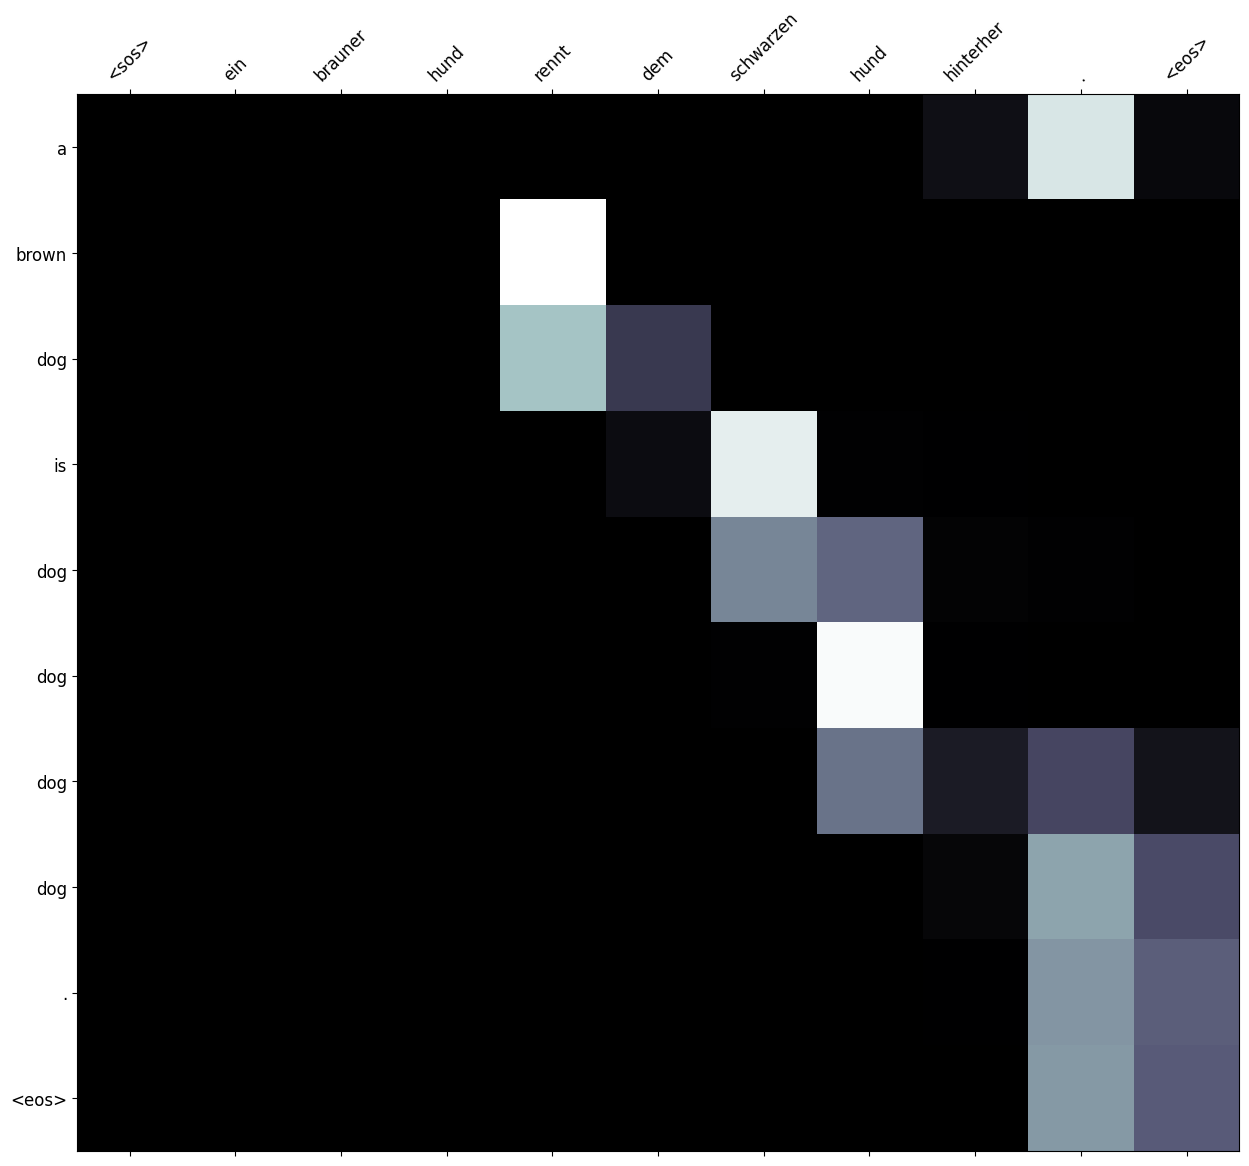

In [39]:
display_attention(src, translation, attention)

### BLEU
- Calculate BLEU for test set

In [40]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):

    trgs = []
    pred_trgs = []

    for datum in data:

        src = vars(datum)['src']
        trg = vars(datum)['trg']

        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)

        #cut off <eos> token
        pred_trg = pred_trg[:-1]

        pred_trgs.append(pred_trg)
        trgs.append([trg])

    return bleu_score(pred_trgs, trgs)

In [41]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 12.67


# Tune the model

## **Building the Model**

### Encoder

In [42]:
class Encoder(nn.Module):
    def __init__(self, input_dim, embed_dim, hidden_dim, num_layers, dropout):
        super().__init__()

        ## TODO: define your model here

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # weight matrix for bilinear attention
        self.proj = nn.Linear(hidden_dim, hidden_dim, bias=False)

        self.embedding = nn.Embedding(input_dim, embed_dim)
        self.net = nn.GRU(embed_dim, hidden_dim, num_layers, bidirectional=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):

        ## TODO: write down the forward step
        emb = self.dropout(self.embedding(src)) # (src_n, b, d)

        output, hidden = self.net(emb) # (src_n, b, num_dir*h), (num_dir*num_layers, b, h)

        hidden = rearrange(hidden, "l b h -> b l h")
        hidden = self.proj(hidden)
        hidden = rearrange(hidden, "b l h -> l b h").contiguous()

        return output, hidden

### Decoder with multiplicative(bilinear) attention

In [43]:
class Decoder(nn.Module):
    def __init__(self, output_dim, embed_dim, hidden_dim, num_layers, dropout):
        super().__init__()

        ## TODO: define your model here

        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.embedding = nn.Embedding(output_dim, embed_dim)
        self.net = nn.GRU(embed_dim+hidden_dim, hidden_dim, num_layers)
        self.fc_out = nn.Linear(hidden_dim*2+embed_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, dec_init_state):

        ## TODO: write down the forward step

        input = rearrange(input, "b -> 1 b") # (1, b)
        emb = self.dropout(self.embedding(input)) # (1, b, d)
        dec_state = dec_init_state

        # bilinear attention
        src_n, b, _ = dec_state.shape

        h = hidden[-1]
        h = rearrange(h, "b h -> b 1 h") # (b, 1, h)
        dec_state = rearrange(dec_state, "n b h -> b n h") # (b, src_n, h)

        attn = torch.bmm(h, rearrange(dec_state, "b n h -> b h n")) # (b, 1, src_n)
        attn = rearrange(attn, "b 1 n -> b n")

        attention = nn.functional.softmax(attn, dim=1) # (b, src_n)
        attention = rearrange(attention, "b n -> b 1 n")
        context = torch.bmm(attention, dec_state) # (b, 1, h)
        context = rearrange(context, "b t h -> t b h") # (1, b, h)

        net_input = torch.cat((emb, context), dim=2) # (1, b, h+d)

        net_output, hidden = self.net(net_input, hidden) # (num_layers, b, h), (num_layers, b, h) * 2 (hidden, cell)

        emb = rearrange(emb, "l b d -> (l b) d") # (num_layers*b, d)
        net_output = rearrange(net_output, "l b h -> (l b) h") # (num_layers*b, h)
        context = rearrange(context, "l b h -> (l b) h") # (num_layers*b, h)

        output = self.fc_out(torch.cat((net_output, context, emb), dim=1)) # (num_layers*b, out_dim)
        attention = rearrange(attention, "b 1 n -> b n")
        return output, hidden, attention


### Sequence-to-sequence model

In [44]:
class Seq2Seq(nn.Module):
    def __init__(self,
                 encoder,
                 decoder,
                 src_pad_idx,
                 trg_pad_idx,
                 device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device


    def forward(self, src, trg):

        ## TODO: write down the forward step

        b = src.shape[1]
        trg_n = trg.shape[0]
        trg_voc_size = self.decoder.output_dim

        output = torch.zeros(trg_n, b, trg_voc_size).to(self.device)

        dec_init_state, hidden = self.encoder(src) # hidden: hidden and cell if using LSTM

        input = trg[0, :]
        for t in range(1, trg_n):
            dec_output, hidden, attention = self.decoder(input, hidden, dec_init_state)

            output[t] = dec_output

            top = dec_output.argmax(1)
            input = top

        return output, attention

### Training the Seq2Seq Model

In [45]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
# define your hyperparameters here
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HIDDEN_DIM = 512
NUM_LAYERS = 2
DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HIDDEN_DIM, NUM_LAYERS, DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HIDDEN_DIM, NUM_LAYERS, DROPOUT)

In [46]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

We initialize model weights

In [47]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights);

We use Adam as our optimizer and CrossEntropyLoss. Also we set to ignore <pad> token in calculating loss

In [48]:
LEARNING_RATE = 0.001

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [49]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

### Training

In [50]:
def train(model, iterator, optimizer, criterion):

    model.train()

    epoch_loss = 0

    for i, batch in enumerate(iterator):

        src = batch.src
        trg = batch.trg

        optimizer.zero_grad()

        # TODO: write down your training code here

        src = rearrange(src, "b n -> n b")
        trg = rearrange(trg, "b n -> n b")
        output, attention = model(src, trg)

        output = rearrange(output[1:], "n b d -> (n b) d") # ((trg_n-1)*b, out_d)
        trg = rearrange(trg[1:], "n b -> (n b)") # ((trg_n-1)*b)

        loss = criterion(output, trg)

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [51]:
# batch = next(iter(train_iterator))

In [52]:
# src = batch.src
# src.shape

In [53]:
# trg = batch.trg
# trg.shape

In [54]:
# print(src)

In [55]:
# src_len = torch.sum(src != 1, dim=1)
# src_len.shape

In [56]:
# src_len

In [57]:
# src_len_idx = torch.sort(src_len, descending=True).indices
# src_len_sorted = src_len[src_len_idx]
# print(src_len_sorted)

In [58]:
# src = src[src_len_idx]
# print(src)

In [59]:
# src = rearrange(src, "b n -> n b")
# trg = rearrange(trg, "b n -> n b")
# src_len_sorted = src_len_sorted.to("cpu")
# output, attention = model(src, src_len_sorted, trg)

In [60]:
# print(output.shape, trg.shape)

In [61]:
# print(output[1:].view(-1, output.shape[-1]).shape)

### Evaluation

In [63]:
def evaluate(model, iterator, criterion):

    model.eval()

    epoch_loss = 0

    with torch.no_grad():

        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            # TODO: write down your training code here

            src = rearrange(src, "b n -> n b")
            trg = rearrange(trg, "b n -> n b")

            output, attention = model(src, trg)

            output = rearrange(output[1:], "n b d -> (n b) d") # ((trg_n-1)*b, out_d)
            trg = rearrange(trg[1:], "n b -> (n b)") # ((trg_n-1)*b)

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

### Train the model through multiple epochs

In [64]:
N_EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(model, train_iterator, optimizer, criterion)
    valid_loss = evaluate(model, valid_iterator, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'my-model-1-b.pt')

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

Epoch: 01 | Time: 0m 52s
	Train Loss: 4.564
	 Val. Loss: 4.299
Epoch: 02 | Time: 0m 52s
	Train Loss: 4.249
	 Val. Loss: 4.009
Epoch: 03 | Time: 0m 52s
	Train Loss: 3.994
	 Val. Loss: 3.855
Epoch: 04 | Time: 0m 53s
	Train Loss: 3.781
	 Val. Loss: 3.709
Epoch: 05 | Time: 0m 52s
	Train Loss: 3.586
	 Val. Loss: 3.566
Epoch: 06 | Time: 0m 52s
	Train Loss: 3.403
	 Val. Loss: 3.458
Epoch: 07 | Time: 0m 52s
	Train Loss: 3.242
	 Val. Loss: 3.416
Epoch: 08 | Time: 0m 52s
	Train Loss: 3.093
	 Val. Loss: 3.384
Epoch: 09 | Time: 0m 52s
	Train Loss: 2.957
	 Val. Loss: 3.333
Epoch: 10 | Time: 0m 52s
	Train Loss: 2.835
	 Val. Loss: 3.316


In [65]:
model.load_state_dict(torch.load('my-model-1-b.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f}')

| Test Loss: 3.343


### Inference

In [66]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):

    model.eval()

    # TODO: write your code

    if isinstance(sentence, str):
        de_processor = spacy.load("de_core_news_sm")
        tokens = [token.text.lower() for token in de_processor(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
    src_indices = [src_field.vocab.stoi[token] for token in tokens]
    src_tensor = rearrange(torch.LongTensor(src_indices), "i -> i 1").to(device)

    with torch.no_grad():
        dec_init_state, hidden_and_cell = model.encoder(src_tensor)

    trg_indices = [trg_field.vocab.stoi[trg_field.init_token]]
    attentions = torch.zeros(max_len, 1, len(src_indices)).to(device)

    for i in range(max_len):
        trg_tensor = torch.LongTensor([trg_indices[-1]]).to(device)

        with torch.no_grad():
            output, hidden_and_cell, attention = model.decoder(trg_tensor, hidden_and_cell, dec_init_state)

        attentions[i] = attention
        pred_token = output.argmax(1).item()
        trg_indices.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break

    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indices]
    decoded_words = trg_tokens[1:]
    decoder_attentions = rearrange(attentions[:len(trg_tokens)-1].detach().cpu(), "m 1 n -> m n")
    return decoded_words, decoder_attentions

In [67]:
example_idx = 6

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['ein', 'brauner', 'hund', 'rennt', 'dem', 'schwarzen', 'hund', 'hinterher', '.']
trg = ['a', 'brown', 'dog', 'is', 'running', 'after', 'the', 'black', 'dog', '.']


In [68]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'brown', 'dog', 'running', 'running', 'black', 'dog', 'dog', '.', '<eos>']


### BLEU
- Calculate BLEU for test set

In [69]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):

    trgs = []
    pred_trgs = []

    for datum in data:

        src = vars(datum)['src']
        trg = vars(datum)['trg']

        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)

        #cut off <eos> token
        pred_trg = pred_trg[:-1]

        pred_trgs.append(pred_trg)
        trgs.append([trg])

    return bleu_score(pred_trgs, trgs)

In [70]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 13.73


# Use bidirectional LSTMs for the encoder

### Encoder

In [71]:
class Encoder(nn.Module):
    def __init__(self, input_dim, embed_dim, hidden_dim, num_layers, dropout):
        super().__init__()

        ## TODO: define your model here

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_dim, embed_dim)
        self.net = nn.LSTM(embed_dim, hidden_dim, num_layers, bidirectional=True)
        self.fc = nn.Linear(2*hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):

        ## TODO: write down the forward step
        emb = self.dropout(self.embedding(src)) # (src_n, b, d)

        output, (h, c) = self.net(emb)

        h = rearrange(h, "(l d) b h -> l d b h", l=self.num_layers, d=2) # d: number of directions
        h = torch.cat((h[:, 0, :, :], h[:, 1, :, :]), dim=2) # concat forward and backward directions

        c = rearrange(c, "(l d) b h -> l d b h", l=self.num_layers, d=2)
        c = torch.cat((c[:, 0, :, :], c[:, 1, :, :]), dim=2)

        hidden = (h, c) # 2 * (1, b, 2h)
        return output, hidden


### Decoder with attention

In [72]:
class Decoder(nn.Module):
    def __init__(self, output_dim, embed_dim, hidden_dim, num_layers, dropout):
        super().__init__()

        ## TODO: define your model here

        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.embedding = nn.Embedding(output_dim, embed_dim)
        self.net = nn.LSTM(hidden_dim*2+embed_dim, 2*hidden_dim, num_layers)
        self.fc_out = nn.Linear(hidden_dim*4+embed_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden_and_cell, dec_init_state):

        ## TODO: write down the forward step

        input = rearrange(input, "b -> 1 b") # (1, b)
        emb = self.dropout(self.embedding(input)) # (1, b, d)
        dec_state = dec_init_state
        hidden, cell = hidden_and_cell

        # basic dot-product attention
        src_n, b, _ = dec_state.shape

        h = hidden[-1]
        h = rearrange(h, "b h -> b 1 h") # (b, 1, 2*h)
        dec_state = rearrange(dec_state, "n b h -> b n h") # (b, src_n, 2*h)

        attn = torch.bmm(h, rearrange(dec_state, "b n h -> b h n")) # (b, 1, src_n)
        attn = rearrange(attn, "b 1 n -> b n")

        attention = nn.functional.softmax(attn, dim=1) # (b, src_n)
        attention = rearrange(attention, "b n -> b 1 n")
        context = torch.bmm(attention, dec_state) # (b, 1, 2*h)
        context = rearrange(context, "b t h -> t b h") # (1, b, 2*h)

        net_input = torch.cat((emb, context), dim=2) # (1, b, 2*h+d)

        net_output, hidden = self.net(net_input, (hidden, cell)) # (1, b, 2*h), (num_layers, b, 2*h) * 2 (hidden, cell)

        emb = rearrange(emb, "1 b d -> b d") # (b, d)
        net_output = rearrange(net_output, "1 b h -> b h") # (b, 2*h)
        context = rearrange(context, "1 b h -> b h") # (b, 2*h)

        output = self.fc_out(torch.cat((net_output, context, emb), dim=1)) # (b, out_dim)
        attention = rearrange(attention, "b 1 n -> b n")
        return output, hidden, attention


### Sequence-to-sequence model

In [73]:
class Seq2Seq(nn.Module):
    def __init__(self,
                 encoder,
                 decoder,
                 src_pad_idx,
                 trg_pad_idx,
                 device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device


    def forward(self, src, trg):

        ## TODO: write down the forward step

        b = src.shape[1]
        trg_n = trg.shape[0]
        trg_voc_size = self.decoder.output_dim

        output = torch.zeros(trg_n, b, trg_voc_size).to(self.device)

        dec_init_state, hidden_and_cell = self.encoder(src)

        input = trg[0, :]
        for t in range(1, trg_n):
            dec_output, hidden_and_cell, attention = self.decoder(input, hidden_and_cell, dec_init_state)

            output[t] = dec_output

            top = dec_output.argmax(1)
            input = top

        return output, attention

### Training the Seq2Seq Model

In [74]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
# define your hyperparameters here
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HIDDEN_DIM = 512
NUM_LAYERS = 1
DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HIDDEN_DIM, NUM_LAYERS, DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HIDDEN_DIM, NUM_LAYERS, DROPOUT)

In [75]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

We initialize model weights

In [76]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights);

We use Adam as our optimizer and CrossEntropyLoss. Also we set to ignore <pad> token in calculating loss

In [77]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [78]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

### Training

In [79]:
def train(model, iterator, optimizer, criterion):

    model.train()

    epoch_loss = 0

    for i, batch in enumerate(iterator):

        src = batch.src
        trg = batch.trg

        optimizer.zero_grad()

        # TODO: write down your training code here

        src = rearrange(src, "b n -> n b")
        trg = rearrange(trg, "b n -> n b")
        output, attention = model(src, trg)

        output = rearrange(output[1:], "n b d -> (n b) d") # ((trg_n-1)*b, out_d)
        trg = rearrange(trg[1:], "n b -> (n b)") # ((trg_n-1)*b)

        loss = criterion(output, trg)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

### Evaluation

In [81]:
def evaluate(model, iterator, criterion):

    model.eval()

    epoch_loss = 0

    with torch.no_grad():

        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            # TODO: write down your training code here

            src = rearrange(src, "b n -> n b")
            trg = rearrange(trg, "b n -> n b")

            output, attention = model(src, trg)

            output = rearrange(output[1:], "n b d -> (n b) d") # ((trg_n-1)*b, out_d)
            trg = rearrange(trg[1:], "n b -> (n b)") # ((trg_n-1)*b)

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [82]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### Train the model through multiple epochs

In [83]:
N_EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(model, train_iterator, optimizer, criterion)
    valid_loss = evaluate(model, valid_iterator, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'my-model-1-c.pt')

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

Epoch: 01 | Time: 1m 19s
	Train Loss: 4.693
	 Val. Loss: 4.479
Epoch: 02 | Time: 1m 19s
	Train Loss: 4.406
	 Val. Loss: 4.214
Epoch: 03 | Time: 1m 19s
	Train Loss: 4.176
	 Val. Loss: 4.045
Epoch: 04 | Time: 1m 18s
	Train Loss: 3.956
	 Val. Loss: 3.867
Epoch: 05 | Time: 1m 18s
	Train Loss: 3.738
	 Val. Loss: 3.709
Epoch: 06 | Time: 1m 18s
	Train Loss: 3.542
	 Val. Loss: 3.590
Epoch: 07 | Time: 1m 18s
	Train Loss: 3.362
	 Val. Loss: 3.514
Epoch: 08 | Time: 1m 18s
	Train Loss: 3.213
	 Val. Loss: 3.462
Epoch: 09 | Time: 1m 18s
	Train Loss: 3.062
	 Val. Loss: 3.401
Epoch: 10 | Time: 1m 19s
	Train Loss: 2.906
	 Val. Loss: 3.392


In [84]:
model.load_state_dict(torch.load('my-model-1-c.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f}')

| Test Loss: 3.390


### Inference and attention visualization

In [85]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):

    model.eval()

    # TODO: write your code

    if isinstance(sentence, str):
        de_processor = spacy.load("de_core_news_sm")
        tokens = [token.text.lower() for token in de_processor(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
    src_indices = [src_field.vocab.stoi[token] for token in tokens]
    src_tensor = rearrange(torch.LongTensor(src_indices), "i -> i 1").to(device)

    with torch.no_grad():
        dec_init_state, hidden_and_cell = model.encoder(src_tensor)

    trg_indices = [trg_field.vocab.stoi[trg_field.init_token]]
    attentions = torch.zeros(max_len, 1, len(src_indices)).to(device)

    for i in range(max_len):
        trg_tensor = torch.LongTensor([trg_indices[-1]]).to(device)

        with torch.no_grad():
            output, hidden_and_cell, attention = model.decoder(trg_tensor, hidden_and_cell, dec_init_state)

        attentions[i] = attention
        pred_token = output.argmax(1).item()
        trg_indices.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break

    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indices]
    decoded_words = trg_tokens[1:]
    decoder_attentions = rearrange(attentions[:len(trg_tokens)-1].detach().cpu(), "m 1 n -> m n")
    return decoded_words, decoder_attentions

In [86]:
example_idx = 6

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['ein', 'brauner', 'hund', 'rennt', 'dem', 'schwarzen', 'hund', 'hinterher', '.']
trg = ['a', 'brown', 'dog', 'is', 'running', 'after', 'the', 'black', 'dog', '.']


In [87]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'brown', 'dog', 'is', 'running', 'a', 'black', 'dog', '.', '<eos>']


### BLEU
- Calculate BLEU for test set

In [88]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):

    trgs = []
    pred_trgs = []

    for datum in data:

        src = vars(datum)['src']
        trg = vars(datum)['trg']

        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)

        #cut off <eos> token
        pred_trg = pred_trg[:-1]

        pred_trgs.append(pred_trg)
        trgs.append([trg])

    return bleu_score(pred_trgs, trgs)

In [89]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 10.60


# Model with Additive Attention instead of Dot-product Attention

### Encoder

In [90]:
class Encoder(nn.Module):
    def __init__(self, input_dim, embed_dim, hidden_dim, num_layers, dropout):
        super().__init__()

        ## TODO: define your model here

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_dim, embed_dim)
        self.net = nn.GRU(embed_dim, hidden_dim, num_layers, bidirectional=True)
        self.fc = nn.Linear(2*hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):

        ## TODO: write down the forward step
        emb = self.dropout(self.embedding(src)) # (src_n, b, d)

        output, hidden = self.net(emb) # (src_n, b, num_dir*h), (num_dir*num_layers, b, h)

        hidden = torch.tanh(self.fc(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1))) # (b, h)

        return output, hidden

### Decoder with additive attention

In [91]:
class Decoder(nn.Module):
    def __init__(self, output_dim, embed_dim, hidden_dim, num_layers, dropout):
        super().__init__()

        ## TODO: define your model here

        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # for attention
        self.attn = nn.Linear(hidden_dim*3, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)

        self.embedding = nn.Embedding(output_dim, embed_dim)
        self.net = nn.GRU(hidden_dim*2+embed_dim, hidden_dim, num_layers)
        self.fc_out = nn.Linear(hidden_dim*3+embed_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, dec_init_state):

        ## TODO: write down the forward step

        input = rearrange(input, "b -> 1 b") # (1, b)
        emb = self.dropout(self.embedding(input)) # (1, b, d)
        dec_state = dec_init_state

        # basic dot-product attention
        src_n, b, _ = dec_state.shape

        if hidden.dim() == 3:
            hidden = hidden[-1]
        elif hidden.dim() == 2:
            hidden = hidden
        else:
            raise ValueError()
        h = repeat(hidden, "b h -> b n h", n=src_n) # (b, src_n, h)
        dec_state = rearrange(dec_state, "n b h -> b n h") # (b, src_n, 2*h)

        e = self.v(torch.tanh(self.attn(torch.cat((h, dec_state), dim=2)))) # (b, src_n, 1)
        e = rearrange(e, "b n 1 -> b n")

        attention = nn.functional.softmax(e, dim=1) # (b, src_n)
        attention = rearrange(attention, "b n -> b 1 n")

        context = torch.einsum("b t n, b n h -> b t h", attention, dec_state) # (b, 1, 2*h)
        context = rearrange(context, "b t h -> t b h") # (1, b, 2*h)

        net_input = torch.cat((emb, context), dim=2) # (1, b, 2*h+d)
        hidden = rearrange(hidden, "b h -> 1 b h") # (1, b, h)

        net_output, hidden = self.net(net_input, hidden) # (num_layers, b, h), (num_layers, b, h)

        emb = rearrange(emb, "1 b d -> b d") # (b, d)
        net_output = rearrange(net_output, "1 b h -> b h") # (b, h)
        context = rearrange(context, "1 b h -> b h") # (b, 2*h)

        output = self.fc_out(torch.cat((net_output, context, emb), dim=1)) # (b, out_dim)
        attention = rearrange(attention, "b 1 n -> b n")
        return output, hidden, attention


### Sequence-to-sequence model

In [92]:
class Seq2Seq(nn.Module):
    def __init__(self,
                 encoder,
                 decoder,
                 src_pad_idx,
                 trg_pad_idx,
                 device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device


    def forward(self, src, trg):

        ## TODO: write down the forward step

        b = src.shape[1]
        trg_n = trg.shape[0]
        trg_voc_size = self.decoder.output_dim

        output = torch.zeros(trg_n, b, trg_voc_size).to(self.device)

        dec_init_state, hidden = self.encoder(src) # hidden: hidden and cell if using LSTM

        input = trg[0, :]
        for t in range(1, trg_n):
            dec_output, hidden, attention = self.decoder(input, hidden, dec_init_state)

            output[t] = dec_output

            top = dec_output.argmax(1)
            input = top

        return output, attention

### Training the Seq2Seq Model

In [93]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
# define your hyperparameters here
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HIDDEN_DIM = 512
NUM_LAYERS = 1
DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HIDDEN_DIM, NUM_LAYERS, DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HIDDEN_DIM, NUM_LAYERS, DROPOUT)

In [94]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

We initialize model weights

In [95]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights);

We use Adam as our optimizer and CrossEntropyLoss. Also we set to ignore <pad> token in calculating loss

In [96]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [97]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

### Training

In [98]:
def train(model, iterator, optimizer, criterion):

    model.train()

    epoch_loss = 0

    for i, batch in enumerate(iterator):

        src = batch.src
        trg = batch.trg

        optimizer.zero_grad()

        # TODO: write down your training code here

        src = rearrange(src, "b n -> n b")
        trg = rearrange(trg, "b n -> n b")
        output, attention = model(src, trg)

        output = rearrange(output[1:], "n b d -> (n b) d") # ((trg_n-1)*b, out_d)
        trg = rearrange(trg[1:], "n b -> (n b)") # ((trg_n-1)*b)

        loss = criterion(output, trg)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

### Evaluation

In [100]:
def evaluate(model, iterator, criterion):

    model.eval()

    epoch_loss = 0

    with torch.no_grad():

        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            # TODO: write down your training code here

            src = rearrange(src, "b n -> n b")
            trg = rearrange(trg, "b n -> n b")

            output, attention = model(src, trg)

            output = rearrange(output[1:], "n b d -> (n b) d") # ((trg_n-1)*b, out_d)
            trg = rearrange(trg[1:], "n b -> (n b)") # ((trg_n-1)*b)

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

### Train the model through multiple epochs

In [101]:
N_EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(model, train_iterator, optimizer, criterion)
    valid_loss = evaluate(model, valid_iterator, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'my-model-1-d.pt')

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

Epoch: 01 | Time: 1m 30s
	Train Loss: 4.836
	 Val. Loss: 4.840
Epoch: 02 | Time: 1m 30s
	Train Loss: 4.569
	 Val. Loss: 4.358
Epoch: 03 | Time: 1m 30s
	Train Loss: 4.214
	 Val. Loss: 3.923
Epoch: 04 | Time: 1m 30s
	Train Loss: 3.826
	 Val. Loss: 3.579
Epoch: 05 | Time: 1m 29s
	Train Loss: 3.530
	 Val. Loss: 3.333
Epoch: 06 | Time: 1m 29s
	Train Loss: 3.280
	 Val. Loss: 3.222
Epoch: 07 | Time: 1m 29s
	Train Loss: 3.075
	 Val. Loss: 3.105
Epoch: 08 | Time: 1m 29s
	Train Loss: 2.892
	 Val. Loss: 3.028
Epoch: 09 | Time: 1m 30s
	Train Loss: 2.726
	 Val. Loss: 2.989
Epoch: 10 | Time: 1m 29s
	Train Loss: 2.573
	 Val. Loss: 2.965


In [102]:
model.load_state_dict(torch.load('my-model-1-d.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f}')

| Test Loss: 2.965


### Inference and attention visualization

In [103]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):

    model.eval()

    # TODO: write your code

    if isinstance(sentence, str):
        de_processor = spacy.load("de_core_news_sm")
        tokens = [token.text.lower() for token in de_processor(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
    src_indices = [src_field.vocab.stoi[token] for token in tokens]
    src_tensor = rearrange(torch.LongTensor(src_indices), "i -> i 1").to(device)

    with torch.no_grad():
        dec_init_state, hidden_and_cell = model.encoder(src_tensor)

    trg_indices = [trg_field.vocab.stoi[trg_field.init_token]]
    attentions = torch.zeros(max_len, 1, len(src_indices)).to(device)

    for i in range(max_len):
        trg_tensor = torch.LongTensor([trg_indices[-1]]).to(device)

        with torch.no_grad():
            output, hidden_and_cell, attention = model.decoder(trg_tensor, hidden_and_cell, dec_init_state)

        attentions[i] = attention
        pred_token = output.argmax(1).item()
        trg_indices.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break

    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indices]
    decoded_words = trg_tokens[1:]
    decoder_attentions = rearrange(attentions[:len(trg_tokens)-1].detach().cpu(), "m 1 n -> m n")
    return decoded_words, decoder_attentions

In [104]:
def display_attention(sentence, translation, attention):

    # Set up figure with colorbar
    fig = plt.figure(figsize=(15,25))

    ax = fig.add_subplot(111)

    cax = ax.matshow(attention.numpy(), cmap='bone')

    # Set up axes
    ax.tick_params(labelsize=12)
    ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
                           rotation=45)
    ax.set_yticklabels(['']+translation)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()



In [105]:
example_idx = 6

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['ein', 'brauner', 'hund', 'rennt', 'dem', 'schwarzen', 'hund', 'hinterher', '.']
trg = ['a', 'brown', 'dog', 'is', 'running', 'after', 'the', 'black', 'dog', '.']


In [106]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'brown', 'dog', 'is', 'running', 'black', 'black', 'dog', '.', '<eos>']


<ipython-input-104-32c513eaa5d2>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
<ipython-input-104-32c513eaa5d2>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


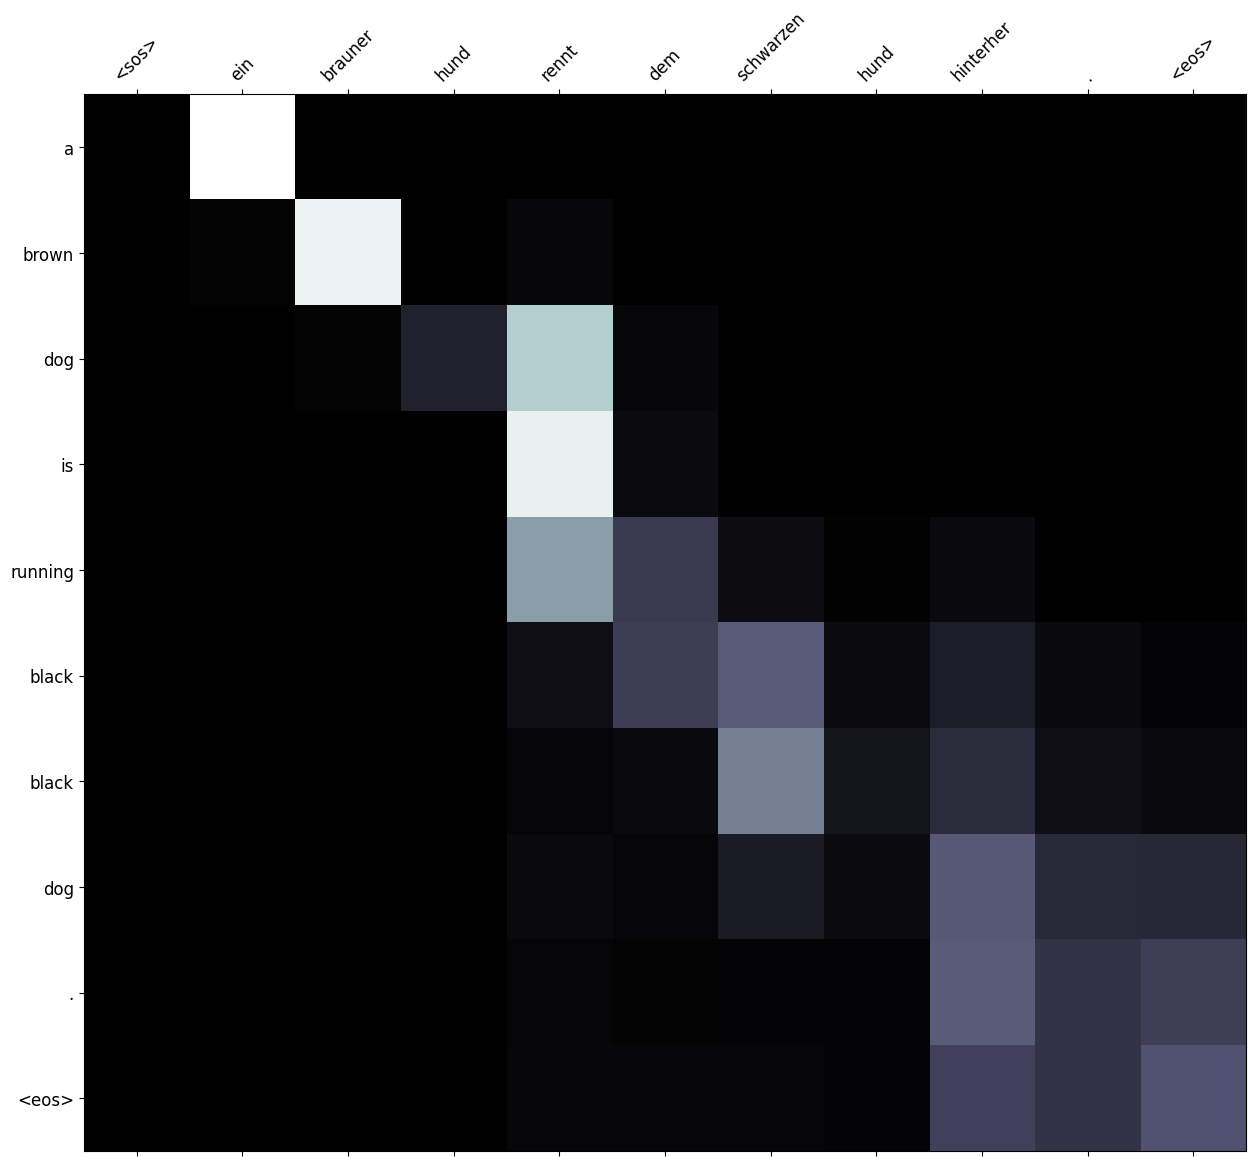

In [107]:
display_attention(src, translation, attention)

### BLEU
- Calculate BLEU for test set

In [108]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):

    trgs = []
    pred_trgs = []

    for datum in data:

        src = vars(datum)['src']
        trg = vars(datum)['trg']

        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)

        #cut off <eos> token
        pred_trg = pred_trg[:-1]

        pred_trgs.append(pred_trg)
        trgs.append([trg])

    return bleu_score(pred_trgs, trgs)

In [109]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 20.69


# Using GloVe embedding

In [ ]:
from torchtext.vocab import GloVe

## build vocabulary with GloVe

In [ ]:
glove_vectors = GloVe(name="6B", dim=300)

In [ ]:
SRC.build_vocab(train_data, min_freq = 2, vectors = glove_vectors)
TRG.build_vocab(train_data, min_freq = 2, vectors = glove_vectors)

In [ ]:
print(f"Unique tokens in source (de) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

In [ ]:
glove_vectors.vectors.shape

### Create the iterators
- we use `BucketIterator` to pack tokens as a batch and convert tokens to indices.

In [112]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    device = device
)

## build the model

### Encoder

In [ ]:
class Encoder(nn.Module):
    def __init__(self, hidden_dim, num_layers, dropout):
        super().__init__()

        ## TODO: define your model here

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        embed_dim = glove_vectors.vectors.shape[1]

        self.embedding = nn.Embedding.from_pretrained(glove_vectors.vectors, freeze=True) # input_dim, embed_dim
        self.net = nn.GRU(embed_dim, hidden_dim, num_layers, bidirectional=True)
        self.fc = nn.Linear(2*hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):

        ## TODO: write down the forward step
        emb = self.dropout(self.embedding(src)) # (src_n, b, d)

        output, hidden = self.net(emb) # (src_n, b, num_dir*h), (num_dir*num_layers, b, h)

        hidden = torch.tanh(self.fc(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1))) # (b, h)

        return output, hidden

### Decoder with additive attention

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, num_layers, dropout):
        super().__init__()

        ## TODO: define your model here

        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # for attention
        self.attn = nn.Linear(hidden_dim*3, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)

        embed_dim = glove_vectors.vectors.shape[1]

        self.embedding = nn.Embedding.from_pretrained(glove_vectors.vectors, freeze=True) # input_dim, embed_dim
        self.net = nn.GRU(hidden_dim*2+embed_dim, hidden_dim, num_layers)
        self.fc_out = nn.Linear(hidden_dim*3+embed_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, dec_init_state):

        ## TODO: write down the forward step

        input = rearrange(input, "b -> 1 b") # (1, b)
        emb = self.dropout(self.embedding(input)) # (1, b, d)
        dec_state = dec_init_state

        # basic dot-product attention
        src_n, b, _ = dec_state.shape

        if hidden.dim() == 3:
            hidden = hidden[-1]
        elif hidden.dim() == 2:
            hidden = hidden
        else:
            raise ValueError()
        h = repeat(hidden, "b h -> b n h", n=src_n) # (b, src_n, h)
        dec_state = rearrange(dec_state, "n b h -> b n h") # (b, src_n, 2*h)

        e = self.v(torch.tanh(self.attn(torch.cat((h, dec_state), dim=2)))) # (b, src_n, 1)
        e = rearrange(e, "b n 1 -> b n")

        attention = nn.functional.softmax(e, dim=1) # (b, src_n)
        attention = rearrange(attention, "b n -> b 1 n")

        context = torch.einsum("b t n, b n h -> b t h", attention, dec_state) # (b, 1, 2*h)
        context = rearrange(context, "b t h -> t b h") # (1, b, 2*h)

        net_input = torch.cat((emb, context), dim=2) # (1, b, 2*h+d)
        hidden = rearrange(hidden, "b h -> 1 b h") # (1, b, h)

        net_output, hidden = self.net(net_input, hidden) # (num_layers, b, h), (num_layers, b, h)

        emb = rearrange(emb, "l b d -> (l b) d") # (b, d)
        net_output = rearrange(net_output, "l b h -> (l b) h") # (b, h)
        context = rearrange(context, "l b h -> (l b) h") # (b, 2*h)

        output = self.fc_out(torch.cat((net_output, context, emb), dim=1)) # (b, out_dim)
        attention = rearrange(attention, "b 1 n -> b n")
        return output, hidden, attention


### Sequence-to-sequence model

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self,
                 encoder,
                 decoder,
                 src_pad_idx,
                 trg_pad_idx,
                 device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device


    def forward(self, src, trg):

        ## TODO: write down the forward step

        b = src.shape[1]
        trg_n = trg.shape[0]
        trg_voc_size = self.decoder.output_dim

        output = torch.zeros(trg_n, b, trg_voc_size).to(self.device)

        dec_init_state, hidden = self.encoder(src) # hidden: hidden and cell if using LSTM

        input = trg[0, :]
        for t in range(1, trg_n):
            dec_output, hidden, attention = self.decoder(input, hidden, dec_init_state)

            output[t] = dec_output

            top = dec_output.argmax(1)
            input = top

        return output, attention

### Training the Seq2Seq Model

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
# define your hyperparameters here
HIDDEN_DIM = 512
NUM_LAYERS = 1
DROPOUT = 0.5

enc = Encoder(HIDDEN_DIM, NUM_LAYERS, DROPOUT)
dec = Decoder(OUTPUT_DIM, HIDDEN_DIM, NUM_LAYERS, DROPOUT)

In [ ]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

We initialize model weights

In [113]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights);

We use Adam as our optimizer and CrossEntropyLoss. Also we set to ignore <pad> token in calculating loss

In [114]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [115]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

### Training

In [116]:
def train(model, iterator, optimizer, criterion):

    model.train()

    epoch_loss = 0

    for i, batch in enumerate(iterator):

        src = batch.src
        trg = batch.trg

        optimizer.zero_grad()

        # TODO: write down your training code here

        src = rearrange(src, "b n -> n b")
        trg = rearrange(trg, "b n -> n b")
        output, attention = model(src, trg)

        output = rearrange(output[1:], "n b d -> (n b) d") # ((trg_n-1)*b, out_d)
        trg = rearrange(trg[1:], "n b -> (n b)") # ((trg_n-1)*b)

        loss = criterion(output, trg)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

### Evaluation

In [117]:
def evaluate(model, iterator, criterion):

    model.eval()

    epoch_loss = 0

    with torch.no_grad():

        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            # TODO: write down your training code here

            src = rearrange(src, "b n -> n b")
            trg = rearrange(trg, "b n -> n b")

            output, attention = model(src, trg)

            output = rearrange(output[1:], "n b d -> (n b) d") # ((trg_n-1)*b, out_d)
            trg = rearrange(trg[1:], "n b -> (n b)") # ((trg_n-1)*b)

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

### Train the model through multiple epochs

In [118]:
N_EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(model, train_iterator, optimizer, criterion)
    valid_loss = evaluate(model, valid_iterator, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'my-model-1-e.pt')

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

Epoch: 01 | Time: 1m 33s
	Train Loss: 5.001
	 Val. Loss: 4.645
Epoch: 02 | Time: 1m 31s
	Train Loss: 4.361
	 Val. Loss: 4.200
Epoch: 03 | Time: 1m 30s
	Train Loss: 3.952
	 Val. Loss: 3.723
Epoch: 04 | Time: 1m 30s
	Train Loss: 3.603
	 Val. Loss: 3.432
Epoch: 05 | Time: 1m 29s
	Train Loss: 3.334
	 Val. Loss: 3.260
Epoch: 06 | Time: 1m 30s
	Train Loss: 3.115
	 Val. Loss: 3.160
Epoch: 07 | Time: 1m 29s
	Train Loss: 2.925
	 Val. Loss: 3.088
Epoch: 08 | Time: 1m 29s
	Train Loss: 2.757
	 Val. Loss: 3.055
Epoch: 09 | Time: 1m 29s
	Train Loss: 2.603
	 Val. Loss: 3.073
Epoch: 10 | Time: 1m 29s
	Train Loss: 2.459
	 Val. Loss: 3.031


In [119]:
model.load_state_dict(torch.load('my-model-1-e.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f}')

| Test Loss: 3.068


### Inference and attention visualization

In [120]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):

    model.eval()

    # TODO: write your code

    if isinstance(sentence, str):
        de_processor = spacy.load("de_core_news_sm")
        tokens = [token.text.lower() for token in de_processor(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
    src_indices = [src_field.vocab.stoi[token] for token in tokens]
    src_tensor = rearrange(torch.LongTensor(src_indices), "i -> i 1").to(device)

    with torch.no_grad():
        dec_init_state, hidden_and_cell = model.encoder(src_tensor)

    trg_indices = [trg_field.vocab.stoi[trg_field.init_token]]
    attentions = torch.zeros(max_len, 1, len(src_indices)).to(device)

    for i in range(max_len):
        trg_tensor = torch.LongTensor([trg_indices[-1]]).to(device)

        with torch.no_grad():
            output, hidden_and_cell, attention = model.decoder(trg_tensor, hidden_and_cell, dec_init_state)

        attentions[i] = attention
        pred_token = output.argmax(1).item()
        trg_indices.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break

    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indices]
    decoded_words = trg_tokens[1:]
    decoder_attentions = rearrange(attentions[:len(trg_tokens)-1].detach().cpu(), "m 1 n -> m n")
    return decoded_words, decoder_attentions

In [121]:
def display_attention(sentence, translation, attention):

    # Set up figure with colorbar
    fig = plt.figure(figsize=(15,25))

    ax = fig.add_subplot(111)

    cax = ax.matshow(attention.numpy(), cmap='bone')

    # Set up axes
    ax.tick_params(labelsize=12)
    ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
                           rotation=45)
    ax.set_yticklabels(['']+translation)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()



In [122]:
example_idx = 6

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['ein', 'brauner', 'hund', 'rennt', 'dem', 'schwarzen', 'hund', 'hinterher', '.']
trg = ['a', 'brown', 'dog', 'is', 'running', 'after', 'the', 'black', 'dog', '.']


In [123]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'brown', 'dog', 'is', 'running', 'black', 'black', 'dog', '.', '<eos>']


<ipython-input-121-32c513eaa5d2>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
<ipython-input-121-32c513eaa5d2>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


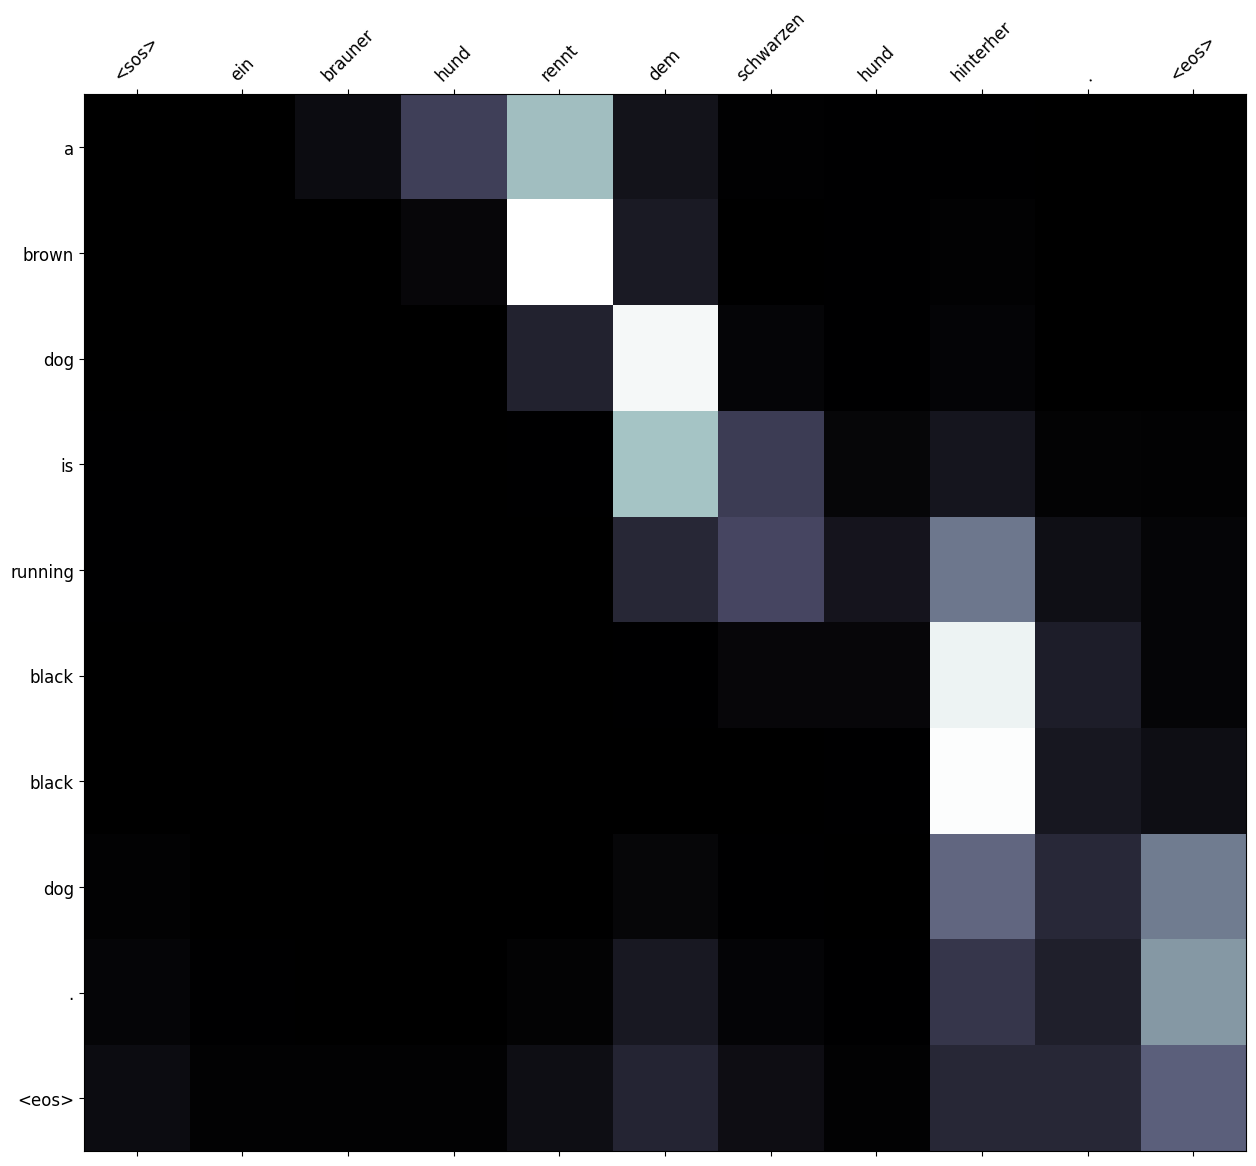

In [124]:
display_attention(src, translation, attention)

### BLEU
- Calculate BLEU for test set

In [125]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):

    trgs = []
    pred_trgs = []

    for datum in data:

        src = vars(datum)['src']
        trg = vars(datum)['trg']

        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)

        #cut off <eos> token
        pred_trg = pred_trg[:-1]

        pred_trgs.append(pred_trg)
        trgs.append([trg])

    return bleu_score(pred_trgs, trgs)

In [126]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 19.58
